>## Use __tfjs__ env 

>**env:**
>1. install python 3.6.8 ``conda create -n ENVNAME python=3.6.8``
>2. ``pip install tensorflowjs``
>3. ``conda install notebook`` (conda manage dependencies more effectively than ``pip``)

In [24]:
import os 
import numpy as np 
import pandas as pd
import shutil
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline

## Check if GPU is working 

In [25]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [26]:
try:
    shutil.rmtree("dataset/data-splited")
    os.remove("save-model.h5")
    os.remove("model.h5")
except:
    print("OK")

OK


In [27]:
import splitfolders
# Splits the dataset
splitfolders.ratio("dataset/data", output="dataset/data-splited", seed=0, ratio=(.7, .15, .15))

Copying files: 105 files [00:00, 314.80 files/s]


In [28]:
from keras.preprocessing.image import ImageDataGenerator

dir_path = "dataset/data-splited"


# Define data augmentation settings
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=False,
                                    fill_mode="constant",
                                    cval=0, #  This will fill the new pixels with black
                                )

train_set = train_datagen.flow_from_directory(
                                            os.path.join(dir_path, "train"),
                                            shuffle=True,
                                            target_size=(224, 224),
                                            batch_size=16,
                                            class_mode="sparse",
                                            )

# Validation and test set
datagen = ImageDataGenerator(rescale=1./255)

val_set = datagen.flow_from_directory(
                                    os.path.join(dir_path, "val"),
                                    shuffle=False,
                                    target_size=(224, 224),
                                    batch_size=16,
                                    class_mode="sparse",
                                    )

test_set = datagen.flow_from_directory(
                                    os.path.join(dir_path, "test"),
                                    shuffle=False,
                                    target_size=(224, 224),
                                    batch_size=16,
                                    class_mode="sparse",
                                    )


Found 72 images belonging to 5 classes.
Found 15 images belonging to 5 classes.


Found 18 images belonging to 5 classes.


In [29]:
# Calculate the number of batches for trainset
total_samples = train_set.n
batch_size = train_set.batch_size
total_batches = (total_samples + batch_size - 1) // batch_size

print(f"Total samples: {total_samples}")
print(f"Batch size: {batch_size}")
print(f"Total batches: {total_batches}")

Total samples: 72
Batch size: 16
Total batches: 5


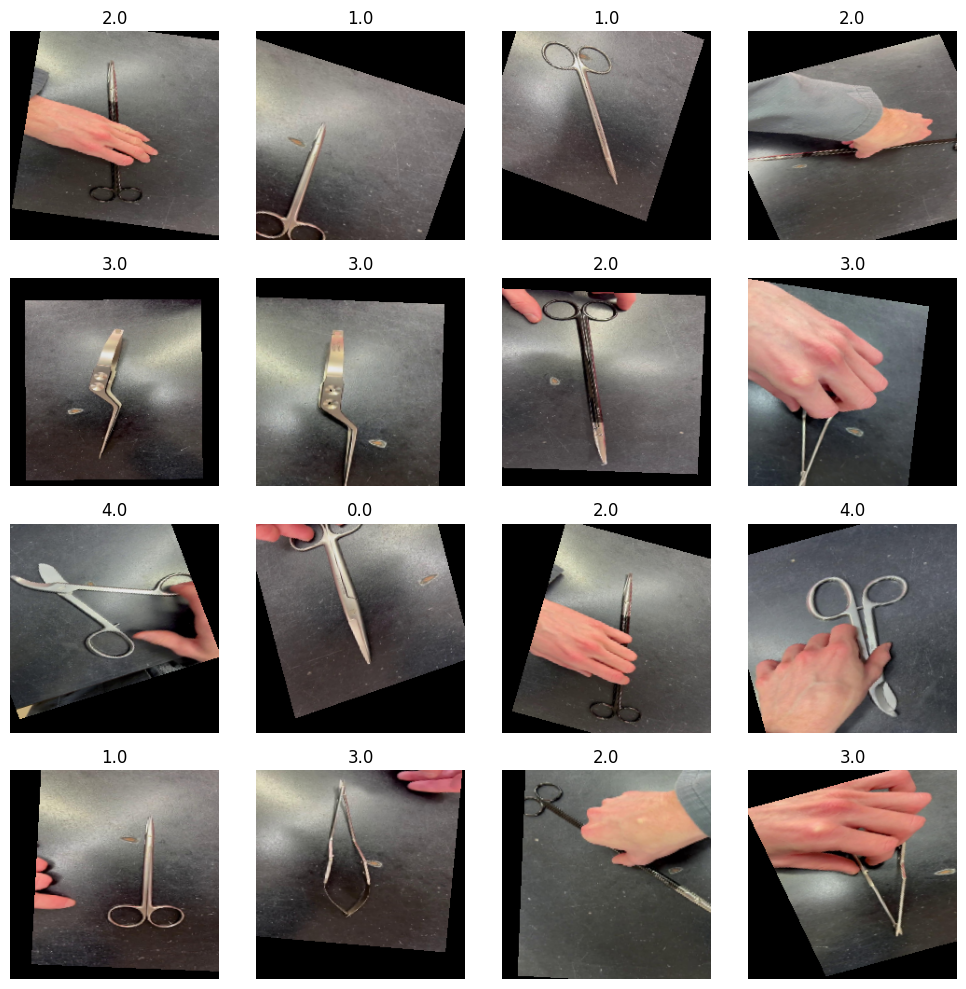

In [30]:
# Extract a batch of images and labels from train_set
images, labels = next(train_set)


# Plotting the first 25 images from the batch

img_train, label_train = next(train_set)

fig, axs =  plt.subplots(4,4, figsize=(10,10))

for i, ax in zip(range(16), axs.ravel()):
    ax.imshow(img_train[i])
    ax.axis('off')
    ax.set_title(label_train[i])
plt.tight_layout()
plt.show()

C:\Users\louis\AppData\Local\Temp\ipykernel_18000\826677915.py:11: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  proportion = pd.value_counts(name.classes, normalize=False, sort=False)


Mean proportion of images in train set: 14
Mean proportion of images in validation set: 3
Mean proportion of images in test set: 4


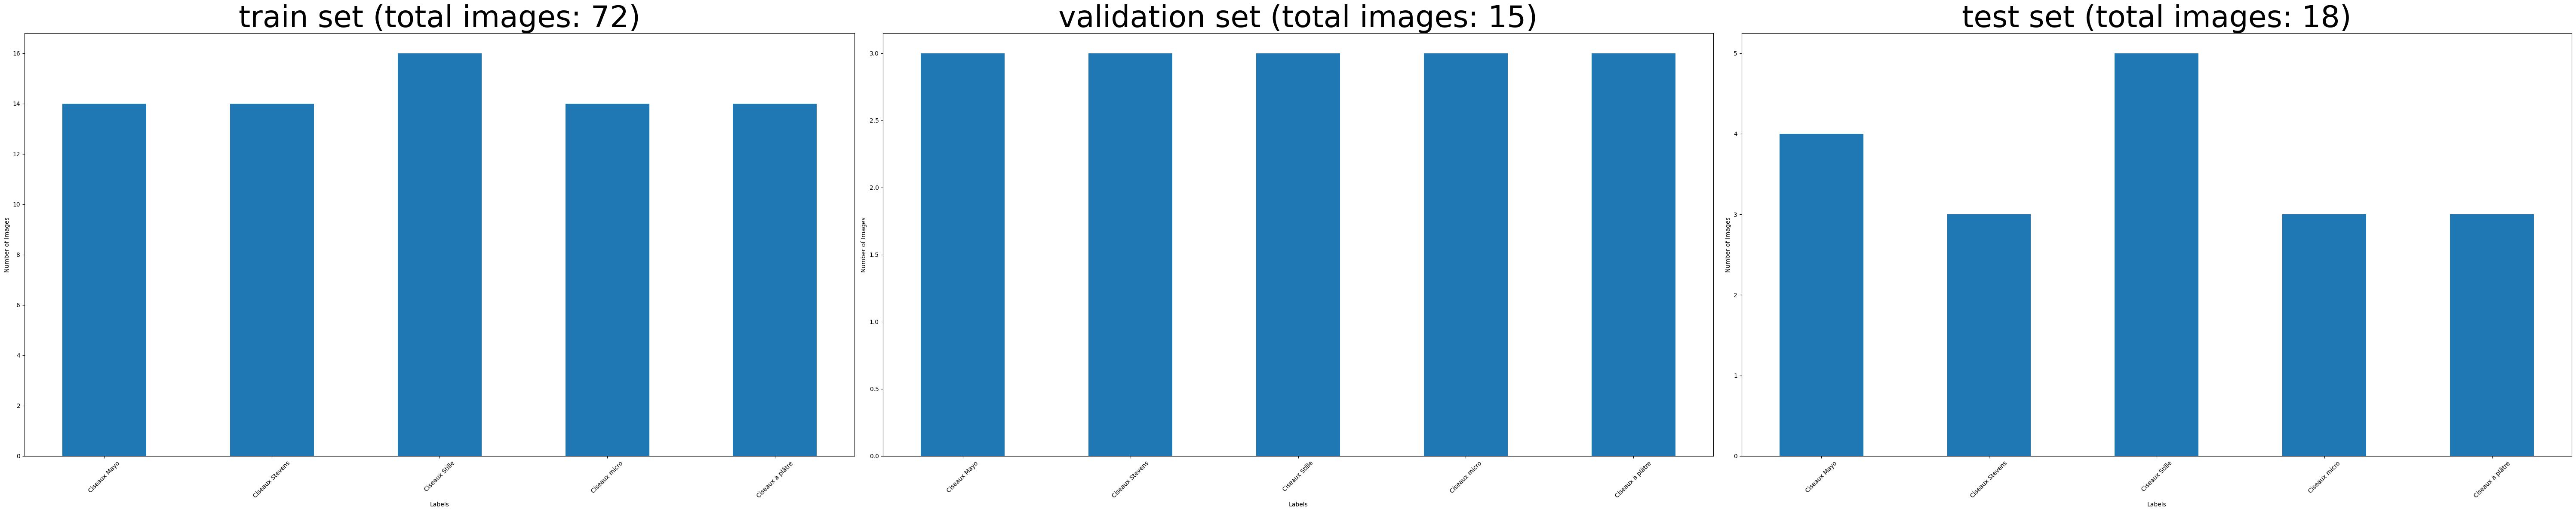

In [31]:
# Setup set names
set_names = ["train set", "validation set", "test set"]
categories = train_set.class_indices.keys()

# Plot
fig, axes = plt.subplots(1, 3, figsize=(60, 12))

for set_name, name, ax in zip(set_names, [train_set, val_set, test_set], axes.ravel()):

    # Get the count of each label in the train set
    proportion = pd.value_counts(name.classes, normalize=False, sort=False)
    print("Mean proportion of images in {}: {:.0f}".format(set_name, proportion.mean()))
    
    ax.bar(categories, proportion, width=0.5)
    ax.set_title(f"{set_name} (total images: {len(name.classes)})", fontsize=50)
    ax.set(
        xlabel="Labels",
        ylabel="Number of Images",
    )
    ax.tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

> # Can't use MobileNetV3Large for tfjs 

In [32]:
import tensorflow.keras as keras
from tensorflow.keras.applications import MobileNetV3Large

""" np.random.seed(0)
tf.set_random_seed(0) """

# Load the pretrained model
base_model =  MobileNetV3Large(input_shape=(224, 224, 3), weights="imagenet", include_top=False, include_preprocessing=False)

# Make layers of the base model trainable
base_model.trainable = False

# Get the number of layers for the base_model
print(f"The base_model has {len(base_model.layers)} layers.")

# Unfreeze the last few layers for fine-tuning
""" fine_tune_at = 255 """

# Freezes the weights of the pre-train model
""" for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True """


# Creat a new classification layers on top
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
""" x = keras.layers.Dropout(0.2)(x) """
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
outputs = keras.layers.Dense(train_set.num_classes, activation="softmax")(x)

# Define the model
model = keras.Model(inputs=base_model.input, outputs=outputs)


# Compile the model
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["acc"])

# Print network summary
model.summary()

The base_model has 262 layers.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 112, 112, 16  64         ['Conv[0][0]']                   
 tion)                          )                            

In [33]:
import tensorflow.keras as keras
from tensorflow.keras.applications import MobileNetV2

""" 
np.random.seed(0)
tf.set_random_seed(0) """

# Load the pretrained model
base_model =  MobileNetV2(input_shape=(224, 224, 3), weights="imagenet", include_top=False)

# Make layers of the base model trainable
base_model.trainable = False

# Get the number of layers for the base_model
print(f"The base_model has {len(base_model.layers)} layers.")

# Unfreeze the last few layers for fine-tuning
""" fine_tune_at = 255 """

# Freezes the weights of the pre-train model
""" for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True """


# Creat a new classification layers on top
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
""" x = keras.layers.Dropout(0.2)(x) """
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
outputs = keras.layers.Dense(train_set.num_classes, activation="softmax")(x)

# Define the model
model = keras.Model(inputs=base_model.input, outputs=outputs)


# Compile the model
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["acc"])

# Print network summary
model.summary()

The base_model has 154 layers.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                            

In [34]:
### Code to train the model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# End trainging whe accuracy stops improving
early_stopping = EarlyStopping(monitor="val_loss", patience=20)

# Reduce learning rate if val_loss doesn't improve
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1,
                              patience=3, min_lr=1e-10)

# Define model checkpoint
checkpoint = ModelCheckpoint("save-model.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

# Fit model
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=200,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1,
    workers=1, # Number of workers Depend on your configuration
)

Epoch 1/200
5/5 [==============================] - ETA: 0s - loss: 1.7147 - acc: 0.1667
Epoch 1: val_loss improved from inf to 1.45871, saving model to save-model.h5
5/5 [==============================] - 15s 683ms/step - loss: 1.7147 - acc: 0.1667 - val_loss: 1.4587 - val_acc: 0.2000 - lr: 0.0010
Epoch 2/200
5/5 [==============================] - ETA: 0s - loss: 1.3054 - acc: 0.4167
Epoch 2: val_loss improved from 1.45871 to 1.16011, saving model to save-model.h5
5/5 [==============================] - 2s 292ms/step - loss: 1.3054 - acc: 0.4167 - val_loss: 1.1601 - val_acc: 0.4000 - lr: 0.0010
Epoch 3/200
5/5 [==============================] - ETA: 0s - loss: 0.7121 - acc: 0.7083
Epoch 3: val_loss improved from 1.16011 to 0.55043, saving model to save-model.h5
5/5 [==============================] - 2s 373ms/step - loss: 0.7121 - acc: 0.7083 - val_loss: 0.5504 - val_acc: 0.8000 - lr: 0.0010
Epoch 4/200
5/5 [==============================] - ETA: 0s - loss: 0.3012 - acc: 0.8750
Epoch 4: 

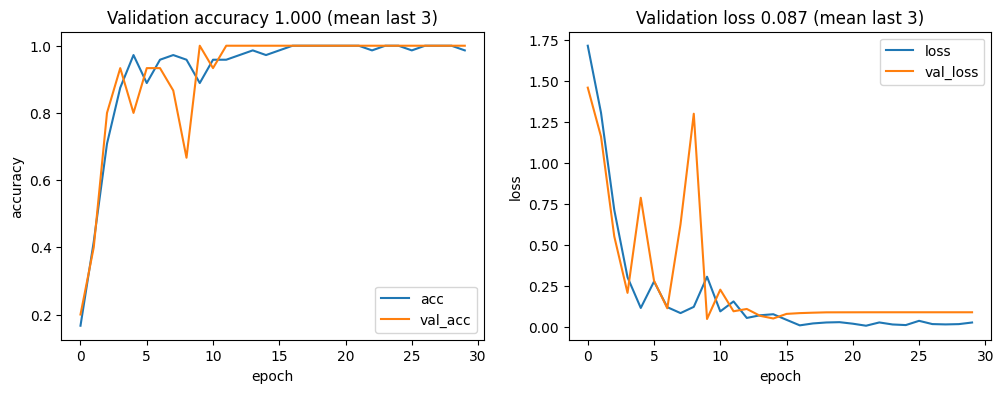

In [35]:
# Plots neural network performance metrics for train and validation
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Get the performance metrics
results = pd.DataFrame(history.history)

# Plot accuracy curves
results[["acc", "val_acc"]].plot(ax=ax1)
ax1.set_title(
    "Validation accuracy {:.3f} (mean last 3)".format(
        np.mean(results["val_acc"][-3:]) # Last three values
    )
)
ax1.set_xlabel("epoch")
ax1.set_ylabel("accuracy")

# Plot loss curves
results[["loss", "val_loss"]].plot(ax=ax2)
ax2.set_title(
    "Validation loss {:.3f} (mean last 3)".format(
        np.mean(results["val_loss"][-3:]) # Last three values
    )
)
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")

plt.show()

In [36]:
# Due to the use of a old version of python this code below will not work !

""" from sklearn.metrics import ConfusionMatrixDisplay

test_pred = model.predict(test_set)

# Compute the heigths probability for each entry
test_pred_labels = np.argmax(test_pred, axis=1)


# Plot Confusion Matrix
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay.from_predictions(test_set.labels, test_pred_labels, ax=ax0)
ax0.set_title("Confusion Matrix values")

ConfusionMatrixDisplay.from_predictions(test_set.labels, test_pred_labels, normalize="true", ax=ax1)
ax1.set_title("Confusion Matrix percentage")
 
plt.show()"""

' from sklearn.metrics import ConfusionMatrixDisplay\n\ntest_pred = model.predict(test_set)\n\n# Compute the heigths probability for each entry\ntest_pred_labels = np.argmax(test_pred, axis=1)\n\n\n# Plot Confusion Matrix\nfig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))\n\nConfusionMatrixDisplay.from_predictions(test_set.labels, test_pred_labels, ax=ax0)\nax0.set_title("Confusion Matrix values")\n\nConfusionMatrixDisplay.from_predictions(test_set.labels, test_pred_labels, normalize="true", ax=ax1)\nax1.set_title("Confusion Matrix percentage")\n \nplt.show()'

2/2 [==============================] - 2s 285ms/step


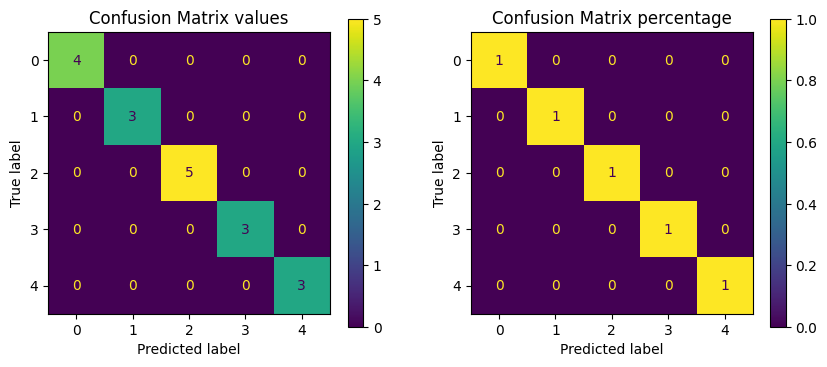

In [37]:
### Old vesion 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_pred = model.predict(test_set)

# Compute the heigths probability for each entry
test_pred_labels = np.argmax(test_pred, axis=1)

cm = confusion_matrix(test_set.labels, test_pred_labels)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

# Display Confusion Matrix
disp0 = ConfusionMatrixDisplay(confusion_matrix=cm)
disp0.plot(ax=ax0)
ax0.set_title("Confusion Matrix values")

# Display Normalized Confusion Matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp1.plot(ax=ax1)
ax1.set_title("Confusion Matrix percentage")

plt.show()


In [38]:
# Compute score on the test set
(test_loss, test_accuracy) = model.evaluate(test_set)

print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2%}".format(test_accuracy))

2/2 [==============================] - 0s 18ms/step - loss: 0.0340 - acc: 1.0000
Test loss: 0.03
Test accuracy: 100.00%


In [39]:
np.round(test_pred * 100)

array([[ 98.,   1.,   1.,   0.,   0.],
       [ 87.,   1.,   9.,   3.,   0.],
       [ 99.,   0.,   0.,   0.,   0.],
       [ 97.,   1.,   1.,   1.,   0.],
       [  0., 100.,   0.,   0.,   0.],
       [  0., 100.,   0.,   0.,   0.],
       [  1.,  98.,   1.,   0.,   0.],
       [  0.,   0., 100.,   0.,   0.],
       [  0.,   0., 100.,   0.,   0.],
       [  0.,   1.,  72.,   0.,  27.],
       [  1.,   3.,  96.,   0.,   0.],
       [  0.,   2.,  98.,   0.,   0.],
       [  0.,   0.,   0., 100.,   0.],
       [  0.,   0.,   0., 100.,   0.],
       [  0.,   0.,   0., 100.,   0.],
       [  0.,   0.,   0.,   0., 100.],
       [  0.,   0.,   0.,   0., 100.],
       [  0.,   0.,   0.,   0., 100.]], dtype=float32)

In [40]:
model.save("model.h5")

# To do check dataset and see if images are not good. try to have 100% accuray 

In [41]:
filenames = os.listdir("dataset/row-data-test")
filenames

['Ciseaux Mayo', 'Ciseaux micro', 'Ciseaux Stevens', 'Ciseaux Stille']

In [42]:
""" # Directory where the files are located
source_directory = "dataset/row-data-test"

# Loop through each filename
for filename in filenames:
    # Create a folder with the filename (without the extension)
    folder_name = os.path.splitext(filename)[0]
    folder_path = os.path.join(source_directory, folder_name)
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Move the file to the folder
    source_file_path = os.path.join(source_directory, filename)
    destination_file_path = os.path.join(folder_path, filename)
    
    shutil.move(source_file_path, destination_file_path)

print("Files have been moved to their respective folders.") """

' # Directory where the files are located\nsource_directory = "dataset/row-data-test"\n\n# Loop through each filename\nfor filename in filenames:\n    # Create a folder with the filename (without the extension)\n    folder_name = os.path.splitext(filename)[0]\n    folder_path = os.path.join(source_directory, folder_name)\n    \n    if not os.path.exists(folder_path):\n        os.makedirs(folder_path)\n\n    # Move the file to the folder\n    source_file_path = os.path.join(source_directory, filename)\n    destination_file_path = os.path.join(folder_path, filename)\n    \n    shutil.move(source_file_path, destination_file_path)\n\nprint("Files have been moved to their respective folders.") '

In [43]:
test = datagen.flow_from_directory(
                                    os.path.join("dataset", "row-data-test"),
                                    shuffle=False,
                                    target_size=(224, 224),
                                    batch_size=1,
                                    class_mode="sparse",
                                    )

Found 4 images belonging to 4 classes.


In [44]:
# Compute score on the test set
(loss, accuracy) = model.evaluate(test)

print("Test loss: {:.2f}".format(loss))
print("Test accuracy: {:.2%}".format(accuracy))

4/4 [==============================] - 0s 82ms/step - loss: 2.9796 - acc: 0.2500
Test loss: 2.98
Test accuracy: 25.00%


In [45]:
classes = {num: name for name, num in test.class_indices.items()}
classes

{0: 'Ciseaux Mayo',
 1: 'Ciseaux Stevens',
 2: 'Ciseaux Stille',
 3: 'Ciseaux micro'}

In [46]:
predition = model.predict(test)
predition

4/4 [==============================] - 0s 120ms/step


array([[1.94024369e-01, 7.79117763e-01, 2.79469346e-03, 9.63803846e-04,
        2.30994206e-02],
       [2.22561564e-02, 9.35416758e-01, 8.94130091e-04, 3.53316253e-04,
        4.10796143e-02],
       [1.86575588e-03, 1.22677736e-01, 3.87706258e-03, 3.66009015e-04,
        8.71213496e-01],
       [5.65676601e-04, 9.89265323e-01, 5.85885253e-04, 9.47368052e-03,
        1.09475259e-04]], dtype=float32)

In [47]:
for i in predition.argmax(axis=1):
    print(f"Image {i +1} is: {classes.get(i)}")

Image 2 is: Ciseaux Stevens
Image 2 is: Ciseaux Stevens
Image 5 is: None
Image 2 is: Ciseaux Stevens


## Save the model to json using tensorflowjs

In [48]:
""" import tensorflowjs as tfjs


tfjs.converters.save_keras_model(model, "js-model") """

' import tensorflowjs as tfjs\n\n\ntfjs.converters.save_keras_model(model, "js-model") '